# Logistic Regression with a Neural Network mindset

This is first programming assignment. You will build a logistic regression classifier to recognize cats. This assignment will step you through how to do this with a Neural Network mindset, and so will also hone your intuitions about deep learning.

**Instructions**
따로 명시한 경우를 제외하고 loop문 (for/while) 사용하지 않기

**You will learn to:**
- Build the general architecture of a learning algorithm, including:
    - 파라미터 초기화
    - cost function과 gradient 계산
    - Gradient Descent
- 위의 3가지 함수를 올바른 순서대로 합치기.

## 1 - Packages

In [110]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
# from lr_utils import load_dataset 

In [111]:
# lr_utils의 load_dataset
def load_dataset():
    train_dataset = h5py.File('../data/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels
    test_dataset = h5py.File('../data/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels
    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

## 2 - Overview of the Problem set
You are given a dataset containing:
    - a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
    - a test set of m_test images labeled as cat or non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels(RGB). Thus, each image is squre (height = num_px) and (width = num_px)
    
You will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.
Let's get more familiar with the dataset. Load the data by running the following code.

In [112]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

We added "_orig" at the end of image datasets because we are going to preprocess them. After preprocessing, we will end up with train_set_x and test_setx(the labels train_set_y and test_set_y don't need any preprocessing).

Each line of your train_set_x_orig and test_set_x_orig is an array representing an image. You can visualize an example by running the following code. Feel free also to change the `index` value and re-run to see other images

y = [0], it's a 'non-cat' picture.


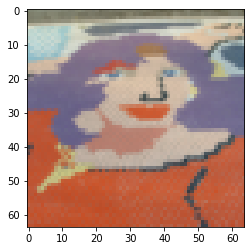

In [113]:
# Example of a picture
index = 105
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:,index]) + ", it's a '" + classes[np.squeeze(train_set_y[:,index])].decode("utf-8") +  "' picture.")

Many software bugs in deep learning come from having matrix/vector dimensions that don't fit. 만약 너가 행렬/벡터의 dimension을 올바르게 유지할 수 있다면, 버그를 줄일 수 있다.

**Exercise:** Find the values for:
    - m_train (number of training examples)
    - m_test (number of test examples)
    - num_px (= height = width of a training image)
    
Remember that `train_set_x_orig` is a numpy-array of shape (m_train, num_px, num_px, 3). For instance, you can access `m_train` by writing `train_set_x_orig.shape[0]`.

In [114]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


For convenience, you should now reshape images of shape (num_px, num_px, 3) in a numpy-array of shape (num_px * num_px * 3, 1). After this, our training (and test) dataset is a numpy-array where each column represents a flattened image. There should be m_train (respectively m_test) columns.

**Exercise:** Reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num_px * num_px * 3, 1).

A trick when you want to flatten a matrix X of shape (a, b, d, c) to a matri _flatten of shape (b * c * d, a) is to use:
    
    X_flatten = X.reshape(X.shape[0], -1).T

In [115]:
train_set_x_flatten = train_set_x_orig.reshape(m_train, -1).T
test_set_x_flatten = test_set_x_orig.reshape(m_test, -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in ml is to center and standardize you dataset. It is simpler and more  convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

Let's standardize our dataset.

In [116]:
train_set_x = train_set_x_flatten / 255
test_set_x = test_set_x_flatten / 255

★ Common steps for pre-processing a new dataset are:
- Figure out the dimensions and shapes of the problem (m_train, m_test, num_px, ...)
- Reshape the datasets such that each example is now a vector of size (num_px * num_px * 3, 1)
- "standardize" the data

## 3 - General Architecture of the learning algorithm
It's time to design a simple algorithm to distinguish cat images from non-cat images.

You will build a Logistic Regression, using a Neural Network mindset.



**Mathematical expression of the algorithm**

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})$$

**Key steps**:
In this exercise, you will carry out the following steps: 
    - 모델 파라미터 초기화
    - Learn the parameters for the model by minimizing the cost  
    - Use the learned parameters to make predictions (on the test set)
    - 결과 분석 및 결론 도출

## 4 - Building the parts of our algorithm

The main steps for building a Neural Network are:
    1. Define the model structure (such as number of input features)
    2. 모델 파라미터 초기화
    3. Loop:
        - forward propagation(loss 계산)
        - backward propagation(gradient 계산)
        - gradient descent(파라미터 업데이트)
        
You often build 1-3 separately and integrate them into one function we call `model()`.


### 4.1 - Helper functions
**Exercise:** Using your code from "Python Basics", implement `sigmoid()`. As you've seen in the figure above, you need to compute $sigmoid( w^T x + b)$ to make predictions.

In [117]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [118]:
print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(9.2) = " + str(sigmoid(9.2)))

sigmoid(0) = 0.5
sigmoid(9.2) = 0.9998989708060922


### 4.2 - Initializing parameters
**Exercise:** Implement parameter initialization in the cell below. You have to initialize w as a vector of zeros. If you don't know what numpy function to use, look up np.zeros() in the Numpy library's documentation.

In [119]:
def initialize_with_zeros(dim): # dim은 파라미터 w의 차원
    w = np.zeros((dim, 1))
    b = 0
    
    assert (w.shape == (dim, 1))
    assert (isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [120]:
dim = 2
w, b = initialize_with_zeros(dim)
print('w = ' + str(w))
print('b = ' + str(b))

w = [[0.]
 [0.]]
b = 0


### 4.3 - Forward and Backward propagation

Now that your parameters are initialized, you can do the 'forward' and 'backward' propagation steps for learning the parameters.

**Exercise:** Implement a function `propagate()` that computes the cost function and its gradient.

**Hints:**

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(0)}, a^{(1)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas you will be using:

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T$$

$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$$

In [121]:
def propagate(w, b, X, Y):
    
    A = sigmoid(np.dot(w.T, X) + b) # (1, m)
    m = X.shape[1]
    
    # elementwise하게 계산함
    cost = (-1/m) * np.sum(Y * np.log(A) + (1-Y) * np.log(1-A))
    
    dw = (1/m) * np.dot(X, (A-Y).T)
    db = (1/m) * np.sum(A-Y) 
    
    grads = {'dw': dw, 'db': db}
    
    assert (dw.shape == w.shape)
    assert (db.dtype == float)
    assert (cost.shape == ())
    
    return grads, cost

In [122]:
w, b, X, Y = np.array([[1], [2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99993216]
 [1.99980262]]
db = 0.49993523062470574
cost = 6.000064773192205


### 4.4 - Optimization
- You have initialized your parameters.
- You are also able to compute a cost function and its gradient.
- Now, you want to update the parameters using gradient descent.

**Exercise:** Write down the optimization function. the goal is to learn `w` and `b` by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $\theta = \theta - \alpha d\theta$, where $\alpha$ is the learning rate.

In [123]:
def optimize(w, b, X, Y, num_iters, lr, print_cost = False):
    
    costs = [] # learning curve 만들 때 사용
    
    for i in range(num_iters):
        grads, cost = propagate(w, b, X, Y)
        w = w - lr*grads['dw'] # need to broadcast
        b = b - lr*grads['db']
        
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
    
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {:.6f}".format(i, cost))
        
    params = {'w':w, 'b':b}
    grads = {'dw':grads['dw'], 'db':grads['db']}
    
    
    return params, grads, costs

In [124]:
params, grads, costs = optimize(w, b, X, Y, num_iters= 100, lr = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.1124579 ]
 [0.23106775]]
b = 1.5593049248448891
dw = [[0.90158428]
 [1.76250842]]
db = 0.4304620716786828


**Exercise:** The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the `predict()` function. There is 2 steps to computing predictions:
   1. Calculate  $\hat{Y} = A = \sigma(w^T X + b)$
   2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector `Y_prediction`. If you wish, you can use an `if/else` statement in a `for loop`(though there is also a way to vecctorize this).

In [125]:
def predict(w, b, X):
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
#         if A[i] > 0.5:
#             Y_prediction[i] = 1
#         else:
#             Y_prediction[i] = 0
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0

        
    assert (Y_prediction.shape == (1, m))
    
    return Y_prediction

In [126]:
print("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1.]]


알고리즘 순서
- (w, b) 초기화
- grads, cost 계산
- gradient descent로 (w, b) 업데이트
- predict

## 5 - Merge all functions into a model

You will now see how the overall model is structured by putting together all the building blocks (functions implemented in the previous parts) together, in the right order.

**Exercise:** Implement the model function. Use the following notation:
    - Y_prediction for your predictions on the test set
    - Y_prediction_train for your predictions on the train set
    - w, costs, grads for the outputs of optimize()

In [127]:
def model(X_train, Y_train, X_test, Y_test, num_iters=2000, lr=0.5, print_cost=False):
    # return d -- dictionary containing information about the model.
    
    # 1) 파라미터 초기화
    w, b = initialize_with_zeros(X_train.shape[0])
    
    # 2) 모델 최적화
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iters, lr, print_cost)
    
    # 3) 파라미터 업데이트
    w = params['w']
    b = params['b']
    
    
    Y_prediction_train = predict(w, b, X_train)
    Y_prediction_test = predict(w, b, X_test)
    
    
    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : lr,
         "num_iterations": num_iters}
    
    return d

In [128]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iters = 2000, lr = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


**Comment:** Training accuracy is close to 100%. This is a good sanity check: your model is working and has high enough capacity to fit the training data. Test accuracy is 70%. It's actually not bad for this simple model, given the small dataset we used and that logistic regression is a linear classifier. But no worries, you'll build an even better classifier next time!

Also, you see that the model is clarly overfitting the training data. Later, you will learn how to reduce overfitting, for example by using regularization. Using the code below (and changing the `index` variable) you can look at predictions on pictures of the test set.

y = 1, you predicted that it is a "cat" picture.


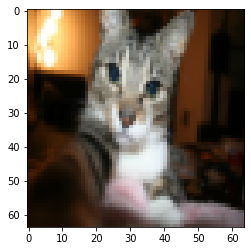

In [129]:
index = 25
plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0, index]) + ", you predicted that it is a \"" + classes[int(d["Y_prediction_test"][0, index])].decode("utf-8") +  "\" picture.")

Let's also plot the cost function and the gradients.

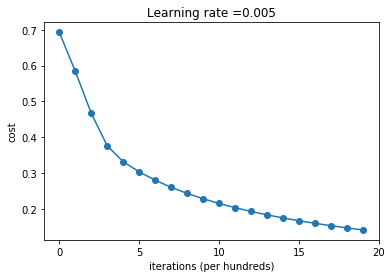

In [130]:
costs = np.squeeze(d['costs'])
plt.plot(costs, marker='o')
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.xticks(np.arange(0, 21, 5))
plt.show();

**Interpretation:** You can see the cost decreasing. It shows that the parameters are being learned. However, you see that you could train the model even more on the training set. Try to increase the number of iterations in the cell above and rerun the cells. You might see that the training set accuracy goes up, but the test accuracy goes down. This is called overfitting.

## 6 - Further analysis(learning rate 선택)

Congratulations on building your first image classification model. Let's analyze it further, and examine possible choices for the learning rate $\alpha$.

**Choice of learning rate**

**Reminder:** In order for Gradient Descent to work you must choose the learning rate wisely. <u>학습률 $\alpha$는 얼마나 빠르게 파라미터를 업데이트 할지를 결정한다.</u> If the learning rate is too large we may "overshoot" the optimal value. Similarly, if it is too small we will need too many iterations to converge to the best values. That's why it is crucial to use a well-tuned learning rate.

Let's compare the learning curve of our model with several choices of learning rats. Run the cell below. This should take about 1 minute. Fell free also to try different values than the three we have initialized the `learning_rates` variable to contain, and see what happens.

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.005
train accuracy: 97.60765550239235 %
test accuracy: 70.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



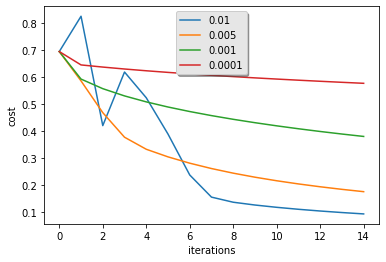

In [131]:
learning_rates = [0.01, 0.005, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iters = 1500, lr = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Interpretation:**
- 학습률이 다르면, cost와 prediction 결과도 달라진다.
- 만약 learning rate이 크다면(0.1), cost는 진동해서 발산할 수도 있다. 
- cost가 작다고 좋은 모델인 것은 아니다. 예를 들어 위에서 0.01인 경우. 이럴 경우엔 overfitting의 가능성을 확인해야 한다. 만약 overfitting하다면, training accuracy가 test accuracy보다 훨씬 높게 나타난다.
- In deep learning, we usually recommend that you:
    - Choose the learning rate that better minimizes the cost function.
    - If your model overfits, use other techniques to reduce overfitting.

## 7 - Test with your own image
You can use your own image and see the output of your model.

y = 0.0, your algorithm predicts a "non-cat" picture.


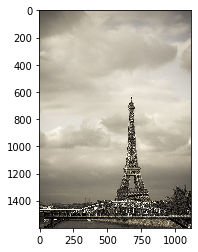

In [132]:
# image -> numpy array
image = np.array(plt.imread('../image/eiffeltower.jpg'))

# image pixel 변환
im = Image.fromarray(image)
my_image = np.array(im.resize((num_px, num_px), Image.BICUBIC)).reshape((1, num_px*num_px*3)).T
my_image_pred = predict(d['w'], d['b'], my_image)

plt.imshow(image)
print("y = 0.0, your algorithm predicts a \"" + classes[int(np.squeeze(my_image_pred)),].decode("utf-8") +  "\" picture.")
# numpy.bytes_ -> str
# classes[int(np.squeeze(my_image_pred)),].decode("utf-8")

1. Preprocessing the dataset is important.
2. You implemented each function separately: `initialize()`, `propagate()`, `optimize()`. Then you built a `model()`.
3. Tuning the learning rate (which is an example of a "hyperparameter") can make a big difference to the algorithm. 

Finally, if you'd like, we invite you to try different things on this Notebook.
   - ~~Play with the learning rate and the number of iterations~~<br>
     → learning rate에 따라서 cost가 바뀜<br>
     → learning rate과 cost가 linear하게 변하지는 않음<br>
     → iterations도 크다고 좋기만 한 것은 아님을 확인했음(500~2000)
     
   - ~~Try different initialization methods and compare the results~~<br>
     → initialization에 따라서도 cost가 바뀜
     
   - Test other preprocessings (center the data, or divide each row by its s.d.)

- Try different initialization methods and compare the results

In [133]:
def initialize_with_zeros(dim): # dim은 파라미터 w의 차원
    mean = 0.05
    std = 0.003
    
    w = np.random.normal(mean, std, (dim, 1))
    b = 0
    
    assert (w.shape == (dim, 1))
    assert (isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [134]:
d2 = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iters = 2000, lr = 0.005, print_cost = True)

Cost after iteration 0: nan


C:\Users\gjai_kmj\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\Users\gjai_kmj\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


Cost after iteration 100: 0.560272
Cost after iteration 200: 0.399542
Cost after iteration 300: 0.356381
Cost after iteration 400: 0.323898
Cost after iteration 500: 0.297551
Cost after iteration 600: 0.275478
Cost after iteration 700: 0.256598
Cost after iteration 800: 0.240205
Cost after iteration 900: 0.225801
Cost after iteration 1000: 0.213024
Cost after iteration 1100: 0.201600
Cost after iteration 1200: 0.191316
Cost after iteration 1300: 0.182005
Cost after iteration 1400: 0.173531
Cost after iteration 1500: 0.165785
Cost after iteration 1600: 0.158676
Cost after iteration 1700: 0.152129
Cost after iteration 1800: 0.146079
Cost after iteration 1900: 0.140471
train accuracy: 99.04306220095694 %
test accuracy: 72.0 %


1) zeros로 설정한 경우
    - train acc : 99.04306220095694%
    - test acc : 70.0%

<br>
2) 정규 분포에서 랜덤 추출하는 경우

- mean = 0, std = 0.1 
    - train acc : 99.04306220095694%
    - test acc : 72.0%
    
- mean = 0, std = 0.3
    - train acc : 95.2153110047847%
    - test acc : 66.0%

- mean = 0.05, std = 0.003
    - train acc : 99.04306220095694%
    - test acc : 72.0%

In [142]:
# 1)과 2)-3번째의 Y_prediction_test 일치율
np.sum(d['Y_prediction_test'] == d2['Y_prediction_test'])/len(d['Y_prediction_test'][0])

0.94

In [143]:
# 원래대로 바꿈
def initialize_with_zeros(dim): # dim은 파라미터 w의 차원
    w = np.zeros((dim, 1))
    b = 0
    
    assert (w.shape == (dim, 1))
    assert (isinstance(b, float) or isinstance(b, int))
    
    return w, b